In [1]:
import os

import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import mannwhitneyu, binomtest
from statsmodels.stats.multitest import multipletests

In [2]:
def an_path(file):
    an_et_al = '40_features_q_mpi_highQCsamples/An_etal.snv.hg19.TSS_flank50Kbp/'
    return os.path.join(an_et_al, file)

def zhou_path(file):
    zhou_et_al = '40_features_q_mpi_highQCsamples/Zhou_etal.snv.hg19.TSS_flank50Kbp/'
    return os.path.join(zhou_et_al, file)

In [3]:
track_mask = np.load(an_path('measured_tracks_mask.npy')).T

In [4]:
n_tracks = track_mask.shape[0] * track_mask.shape[1]
n_measured_tracks = (track_mask != -1).sum()
n_unmeasured_tracks = n_tracks - n_measured_tracks

In [5]:
def load_variants(vcf_file):
    variants = pd.read_csv(vcf_file, sep='\t', header=None)
    variants = variants.drop(columns=[2, 5, 6])
    variants.columns = ["CHROM", "POS", "REF", "ALT", "NOTE"]
    variants[["AUSTATUS", "FIDSID"]] = variants['NOTE'].str.split(';', expand=True)
    variants["AUSTATUS"] = variants["AUSTATUS"].str.slice(start=9)
    variants["FIDSID"] = variants["FIDSID"].str.slice(start=7)
    variants = variants.drop(columns="NOTE")
    variants[["FID", "SID"]] = variants["FIDSID"].str.split('.', expand=True)
    variants = variants.drop(columns="FIDSID")
    return variants

In [6]:
track_metrics = pd.read_csv('40_features_q_mpi_highQCsamples/568000_val_metrics.txt', sep='\t')

In [7]:
best_track = track_metrics.loc[track_metrics[track_metrics["metric_name"] == "average_precision"]["value"].argmax()]

In [8]:
with open('/mnt/datasets/DeepCT/dataset_data/q_features_all/distinct_features_nonTreated.qcfiltered.txt') as f:
    distinct_features = list(map(lambda x: x.rstrip(), f.readlines()))

In [9]:
track_metrics["track_name"] = track_metrics["cell_type"] + "|" + track_metrics["feature"] + "|None"

In [10]:
track_ap = np.full(track_mask.shape, -1.)
ap_mask = (track_metrics["metric_name"] == "average_precision") & (track_metrics["value"].notnull())
for i, track_data in track_metrics[ap_mask].iterrows():
    track_idx = np.where(track_mask == distinct_features.index(track_data["track_name"]))
    track_idx = (track_idx[0][0], track_idx[1][0])
    track_ap[track_idx] = track_data["value"]

In [11]:
best_track

metric_name    average_precision
cell_type                H7-hESC
feature                  H3K4me3
value                   0.779573
Name: 2393, dtype: object

In [12]:
best_track_idx = distinct_features.index(f"{best_track['cell_type']}|{best_track['feature']}|None")
best_track_ct_idx, best_track_feat_idx = np.where(track_mask == best_track_idx)

In [13]:
def bh(pvals, fdr=0.05):
    ranks = np.argsort(pvals) + 1
    n_tests = len(pvals)
    corrected_pvals = []
    for i in range(len(pvals)):
        pval = pvals[i]
        rank = ranks[i]
        corrected_pval = rank / n_tests * fdr
        corrected_pvals.append(corrected_pval)
    corrected_pvals = np.array(corrected_pvals)
    bh_lower_idx = np.where((pvals < corrected_pvals) == True)
    fdr_pval_cutoff = pvals[bh_lower_idx].max()
    return corrected_pvals, fdr_pval_cutoff

In [14]:
len(distinct_features)

2629

# An et al.

In [15]:
# Use (alt - ref) as variant score
#mean_case = np.load(an_path('total_mean_case_effect.npy'))
#mean_control = np.load(an_path('total_mean_control_effect.npy'))

# Use |alt - ref| as variant score
mean_case = np.load(an_path('total_mean_abs_case_effect.npy'))
mean_control = np.load(an_path('total_mean_abs_control_effect.npy'))

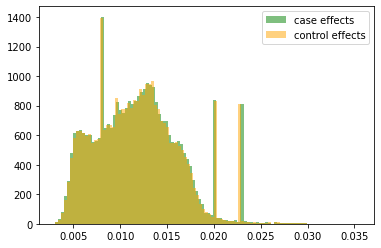

In [16]:
plt.hist(mean_case.flatten(), bins=100, alpha=0.5, color='green', label="case effects")
plt.hist(mean_control.flatten(), bins=100, alpha=0.5, color='orange', label="control effects")
plt.legend()
plt.show()

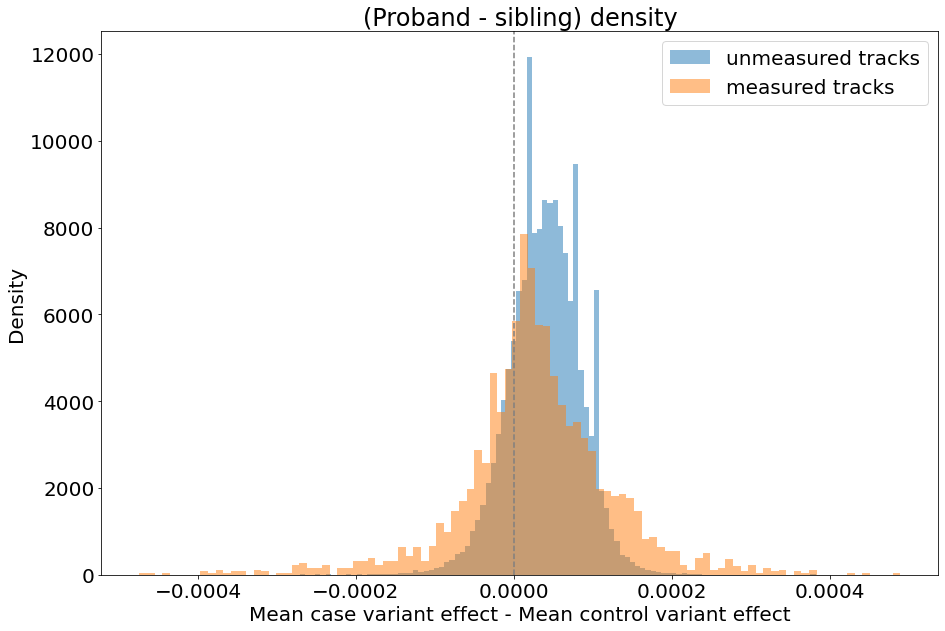

In [21]:
matplotlib.rcParams.update({'font.size': 20})
plt.figure(figsize=(15, 10))

case_control_diff_measured = (mean_case[track_mask != -1] - mean_control[track_mask != -1]).flatten()
case_control_diff_unmeasured = (mean_case[track_mask == -1] - mean_control[track_mask == -1]).flatten()

plt.hist(case_control_diff_unmeasured, density=True, bins=100, alpha=0.5, label="unmeasured tracks")
plt.hist(case_control_diff_measured, density=True, bins=100, alpha=0.5, label="measured tracks")
plt.axvline(0, linestyle='--', c='gray')

plt.xlabel('Mean case variant effect - Mean control variant effect')
plt.ylabel('Density')
plt.title("(Proband - sibling) density")
plt.legend()
plt.show()

In [22]:
compute_pvals = False

if compute_pvals:
    all_case_effects = np.abs(np.load(an_path('all_case_effects.npy')))
    all_control_effects = np.abs(np.load(an_path('all_control_effects.npy')))
    pvals = np.zeros(all_case_effects.shape[1:])
    for ct in range(pvals.shape[0]):
        for feat in range(pvals.shape[1]):
            _, pval = mannwhitneyu(
                all_case_effects[:, ct, feat], all_control_effects[:, ct, feat]
            )
            pvals[ct, feat] = pval
    np.save(an_path('mwu_abs_pvals.npy'), pvals)
else:
    pvals = np.load(an_path('mwu_abs_pvals.npy'))

In [23]:
(pvals < 0.05).sum()

1330

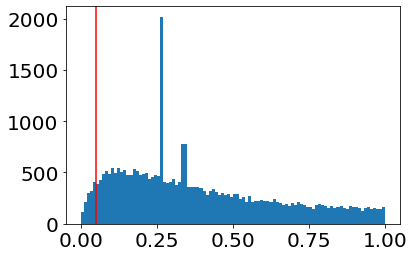

In [24]:
plt.hist(pvals.flatten(), bins=100)
plt.axvline(0.05, c='red')
plt.show()

In [25]:
fdr = 0.1
bh_pvals, fdr_pval_cutoff = bh(pvals.flatten(), fdr=fdr)

In [26]:
case_control_diff = (mean_case - mean_control)
mwu_log_pvals = -np.log10(pvals)

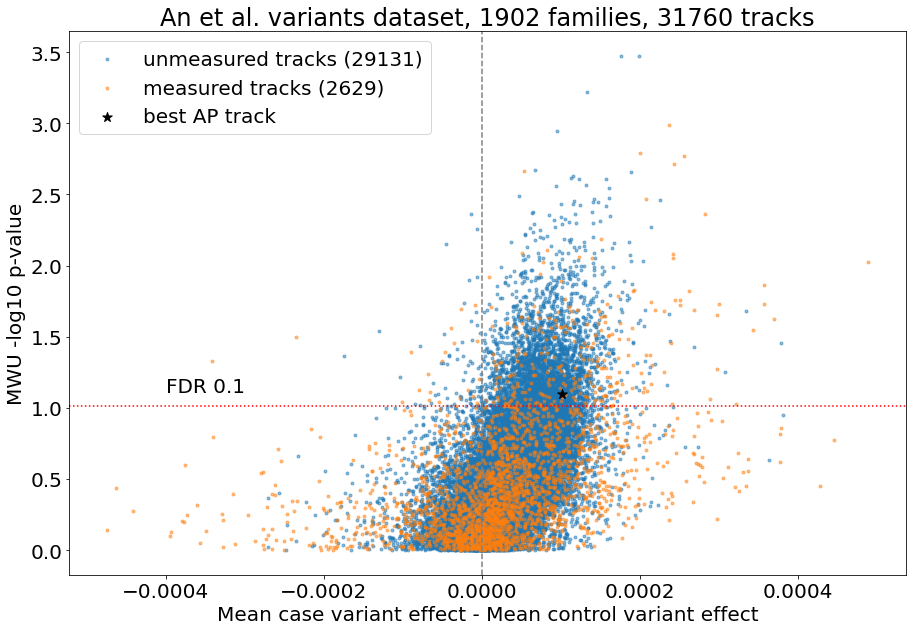

In [29]:
#plt.scatter(case_control_diff_abs, mwu_log_pvals, alpha=0.3, s=2)
matplotlib.rcParams.update({'font.size': 20})
plt.figure(figsize=(15, 10))
plt.scatter(case_control_diff[track_mask == -1], 
            mwu_log_pvals[track_mask == -1], 
            alpha=0.5, s=9, label=f'unmeasured tracks ({n_unmeasured_tracks})')
plt.scatter(case_control_diff[track_mask != -1], 
            mwu_log_pvals[track_mask != -1], 
            alpha=0.5, s=9, label=f'measured tracks ({n_measured_tracks})')
plt.scatter(case_control_diff[best_track_ct_idx, best_track_feat_idx], 
            mwu_log_pvals[best_track_ct_idx, best_track_feat_idx], 
            s=100, marker='*', c='black', label='best AP track')
plt.axhline(-np.log10(fdr_pval_cutoff), linestyle=':', c='red')
plt.text(-0.0004, -np.log10(fdr_pval_cutoff) + 0.1, f'FDR {fdr}')
plt.axvline(0, linestyle='--', c='gray')
plt.xlabel('Mean case variant effect - Mean control variant effect')
plt.ylabel('MWU -log10 p-value')
plt.title(f"An et al. variants dataset, 1902 families, {n_tracks} tracks")
plt.legend()
plt.show()

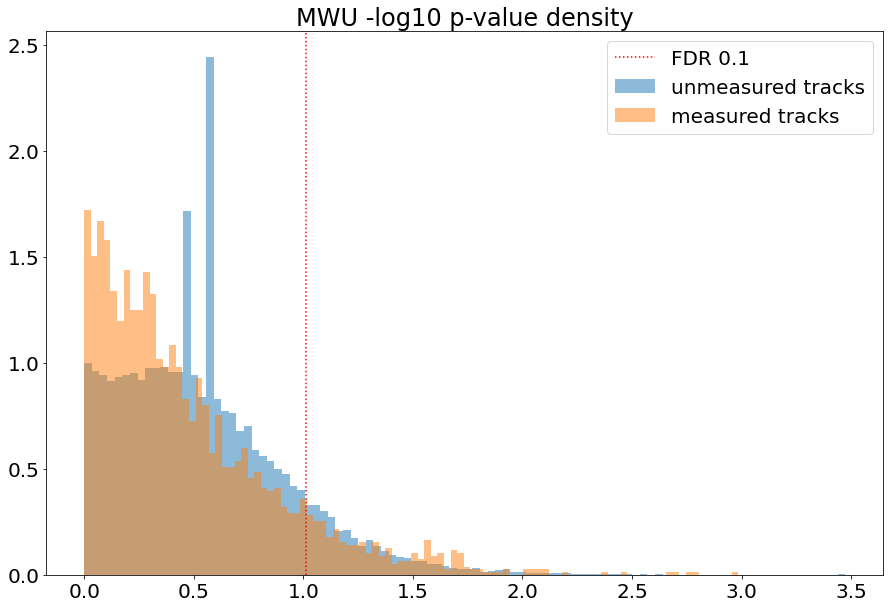

In [30]:
matplotlib.rcParams.update({'font.size': 20})
plt.figure(figsize=(15, 10))
plt.hist(mwu_log_pvals[track_mask == -1].flatten(), bins=100, density=True, alpha=0.5, label="unmeasured tracks")
plt.hist(mwu_log_pvals[track_mask != -1].flatten(), bins=100, density=True, alpha=0.5, label="measured tracks")
plt.axvline(-np.log10(fdr_pval_cutoff), linestyle=':', c='red', label=f'FDR {fdr}')
plt.title('MWU -log10 p-value density')
plt.legend()
plt.show()

In [31]:
(mwu_log_pvals > -np.log10(fdr_pval_cutoff)).sum()

3504

In [32]:
res = mannwhitneyu(mwu_log_pvals[track_mask != -1].flatten(), mwu_log_pvals[track_mask == -1].flatten(),)
res.pvalue

1.397195989999628e-41

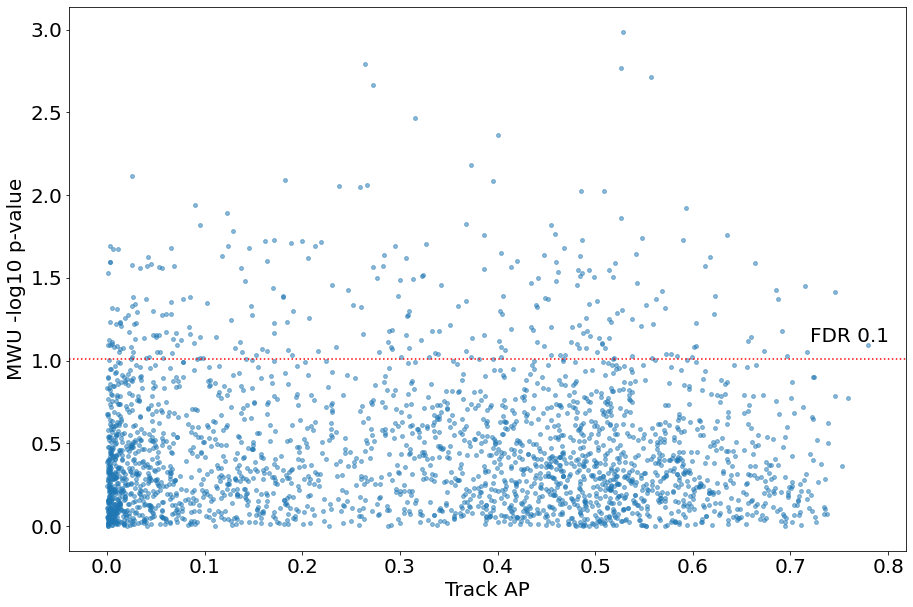

In [35]:
matplotlib.rcParams.update({'font.size': 20})
plt.figure(figsize=(15, 10))
plt.scatter(track_ap[track_ap != -1], mwu_log_pvals[track_ap != -1], s=15, alpha=0.5)
plt.axhline(-np.log10(fdr_pval_cutoff), linestyle=':', c='red')
plt.text(0.72, -np.log10(fdr_pval_cutoff) + 0.1, f'FDR {fdr}')
plt.xlabel('Track AP')
plt.ylabel('MWU -log10 p-value')
plt.show()

## Per-family difference

In [36]:
an_vars = load_variants('An_etal.snv.hg19.TSS_flank50Kbp.vcf')

In [38]:
fid_diffs = []
for fid in an_vars["FID"].unique():
    fid_mean_control = np.abs(np.load(an_path(f'mean_abs_control_effect_{fid}.npy')))
    fid_mean_case = np.abs(np.load(an_path(f'mean_abs_case_effect_{fid}.npy')))
    fid_diffs.append(fid_mean_case - fid_mean_control)
fid_diffs = np.stack(fid_diffs)

In [39]:
best_track_fid_diffs = fid_diffs[:, best_track_ct_idx, best_track_feat_idx]

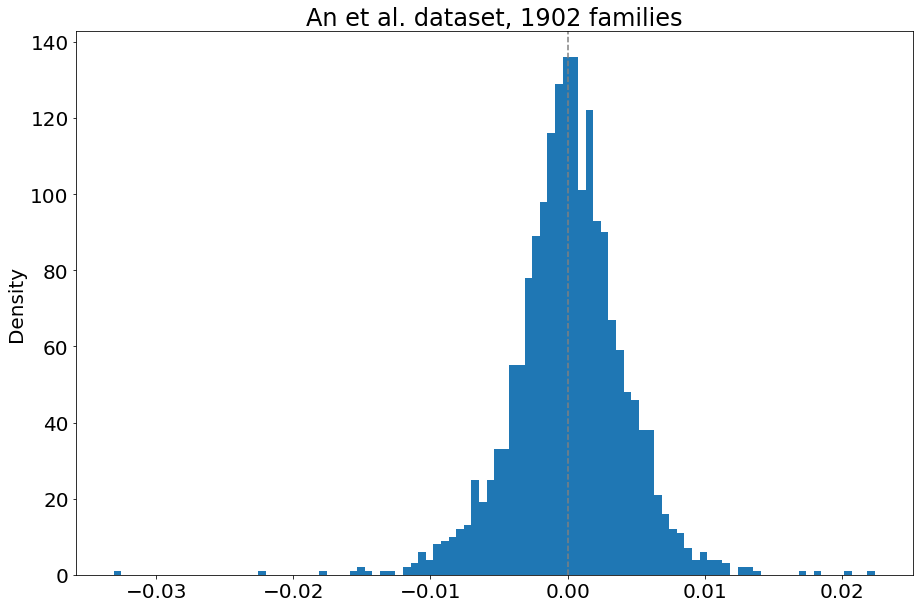

In [40]:
matplotlib.rcParams.update({'font.size': 20})
plt.figure(figsize=(15, 10))
plt.hist(best_track_fid_diffs, bins=100)
plt.title(f"An et al. dataset, {fid_diffs.shape[0]} families")
plt.ylabel('Density')
plt.xlabel('')
plt.axvline(0, linestyle='--', c='gray')
plt.show()

In [41]:
binom_pvals = np.full(fid_diffs.shape[1:], -1.)
for ct_idx in range(fid_diffs.shape[1]):
    for feat_idx in range(fid_diffs.shape[2]):
        track_fid_diffs = fid_diffs[:, ct_idx, feat_idx]
        res = binomtest((track_fid_diffs > 0).sum(), (track_fid_diffs).shape[0])
        binom_pvals[ct_idx, feat_idx] = res.pvalue

In [43]:
binom_pvals[best_track_ct_idx, best_track_feat_idx]

array([0.17609072])

In [42]:
(binom_pvals < 0.05).sum()

850

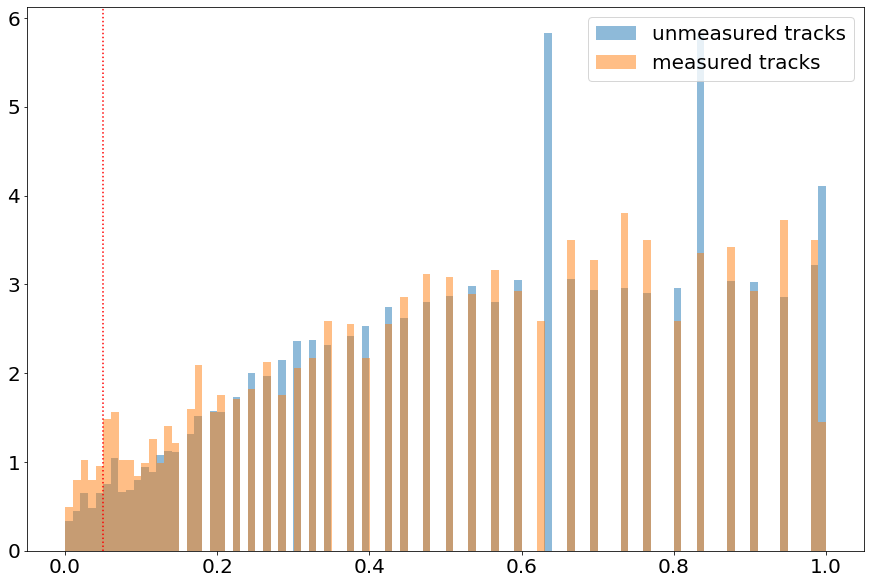

In [44]:
matplotlib.rcParams.update({'font.size': 20})
plt.figure(figsize=(15, 10))
plt.hist(binom_pvals[track_mask == -1].flatten(), density=True, bins=100, alpha=0.5, label="unmeasured tracks")
plt.hist(binom_pvals[track_mask != -1].flatten(), density=True, bins=100, alpha=0.5, label="measured tracks")
plt.axvline(0.05, c='red', linestyle=':')
plt.legend('Per-family (proband-sibling) binomial test p-values')
plt.legend()
plt.show()

# Zhou et al.

In [45]:
# Use (alt - ref) as variant score
#z_mean_case = np.load(zhou_path('total_mean_case_effect.npy'))
#z_mean_control = np.load(zhou_path('total_mean_control_effect.npy'))

# Use |alt - ref| as variant score
z_mean_case = np.load(zhou_path('total_mean_abs_case_effect.npy'))
z_mean_control = np.load(zhou_path('total_mean_abs_control_effect.npy'))

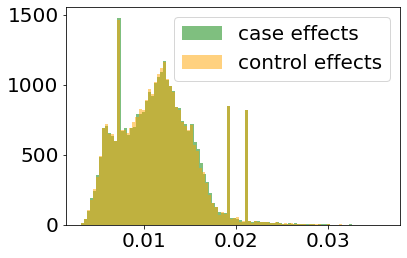

In [46]:
plt.hist(z_mean_case.flatten(), bins=100, alpha=0.5, color='green', label="case effects")
plt.hist(z_mean_control.flatten(), bins=100, alpha=0.5, color='orange', label="control effects")
plt.legend()
plt.show()

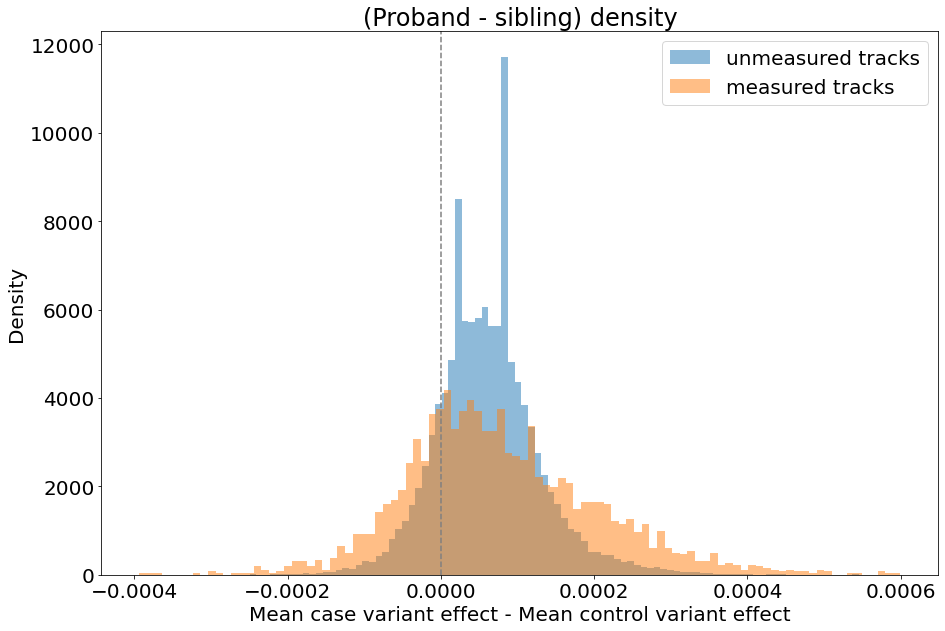

In [48]:
matplotlib.rcParams.update({'font.size': 20})
plt.figure(figsize=(15, 10))

z_case_control_diff_measured = (z_mean_case[track_mask != -1] - z_mean_control[track_mask != -1]).flatten()
z_case_control_diff_unmeasured = (z_mean_case[track_mask == -1] - z_mean_control[track_mask == -1]).flatten()

plt.hist(z_case_control_diff_unmeasured, density=True, bins=100, alpha=0.5, label="unmeasured tracks")
plt.hist(z_case_control_diff_measured, density=True, bins=100, alpha=0.5, label="measured tracks")
plt.axvline(0, linestyle='--', c='gray')

plt.xlabel('Mean case variant effect - Mean control variant effect')
plt.ylabel('Density')
plt.title("(Proband - sibling) density")
plt.legend()
plt.show()

In [49]:
compute_pvals = False

if compute_pvals:
    z_all_case_effects = np.load(zhou_path('all_case_effects.npy'))
    z_all_control_effects = np.load(zhou_path('all_control_effects.npy'))
    z_pvals = np.zeros(z_all_case_effects.shape[1:])
    for ct in range(z_pvals.shape[0]):
        for feat in range(z_pvals.shape[1]):
            _, pval = mannwhitneyu(
                z_all_case_effects[:, ct, feat], z_all_control_effects[:, ct, feat]
            )
            z_pvals[ct, feat] = pval
    np.save(zhou_path('mwu_pvals.npy'), z_pvals)
else:
    z_pvals = np.load(zhou_path('mwu_abs_pvals.npy'))

In [50]:
(z_pvals < 0.05).sum()

5790

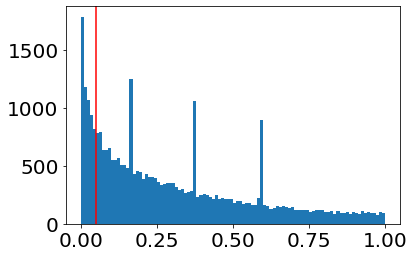

In [51]:
plt.hist(z_pvals.flatten(), bins=100)
plt.axvline(0.05, c='red')
plt.show()

In [52]:
fdr = 0.1
z_bh_pvals, z_fdr_pval_cutoff = bh(z_pvals.flatten(), fdr=fdr)

In [53]:
z_case_control_diff = (z_mean_case - z_mean_control)
z_mwu_log_pvals = -np.log10(z_pvals)

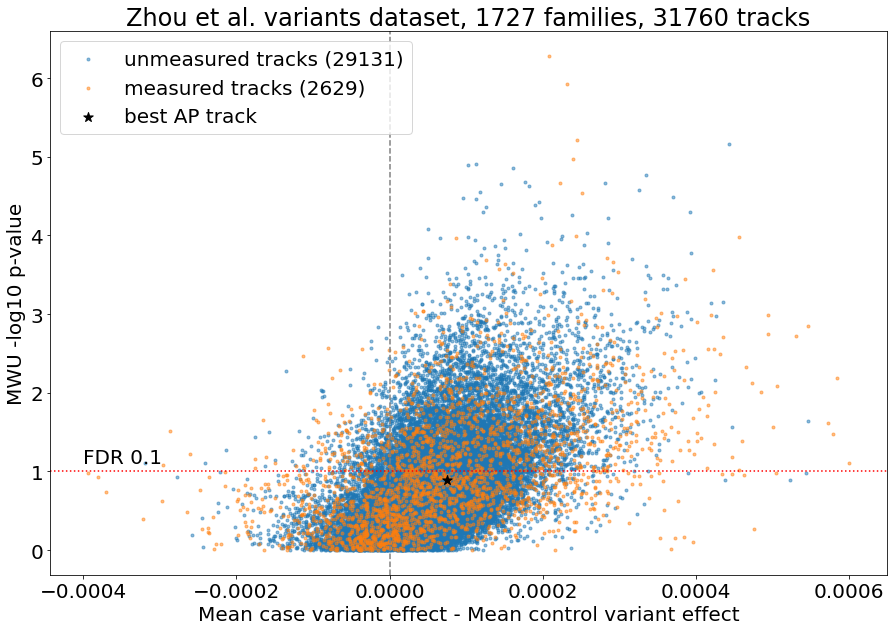

In [65]:
#plt.scatter(case_control_diff_abs, mwu_log_pvals, alpha=0.3, s=2)
matplotlib.rcParams.update({'font.size': 20})
plt.figure(figsize=(15, 10))
plt.scatter(z_case_control_diff[track_mask == -1], 
            z_mwu_log_pvals[track_mask == -1], 
            alpha=0.5, s=9, label=f'unmeasured tracks ({n_unmeasured_tracks})')
plt.scatter(z_case_control_diff[track_mask != -1], 
            z_mwu_log_pvals[track_mask != -1], 
            alpha=0.5, s=9, label=f'measured tracks ({n_measured_tracks})')
plt.scatter(z_case_control_diff[best_track_ct_idx, best_track_feat_idx], 
            z_mwu_log_pvals[best_track_ct_idx, best_track_feat_idx], 
            s=100, marker='*', c='black', label='best AP track')
plt.axhline(-np.log10(z_fdr_pval_cutoff), linestyle=':', c='red')
plt.text(-0.0004, -np.log10(z_fdr_pval_cutoff) + 0.1, f'FDR {fdr}')
plt.axvline(0, linestyle='--', c='gray')
plt.xlabel('Mean case variant effect - Mean control variant effect')
plt.ylabel('MWU -log10 p-value')
plt.title(f"Zhou et al. variants dataset, 1727 families, {n_tracks} tracks")
plt.legend()
plt.show()

In [55]:
(z_mwu_log_pvals > -np.log10(z_fdr_pval_cutoff)).sum()

9135

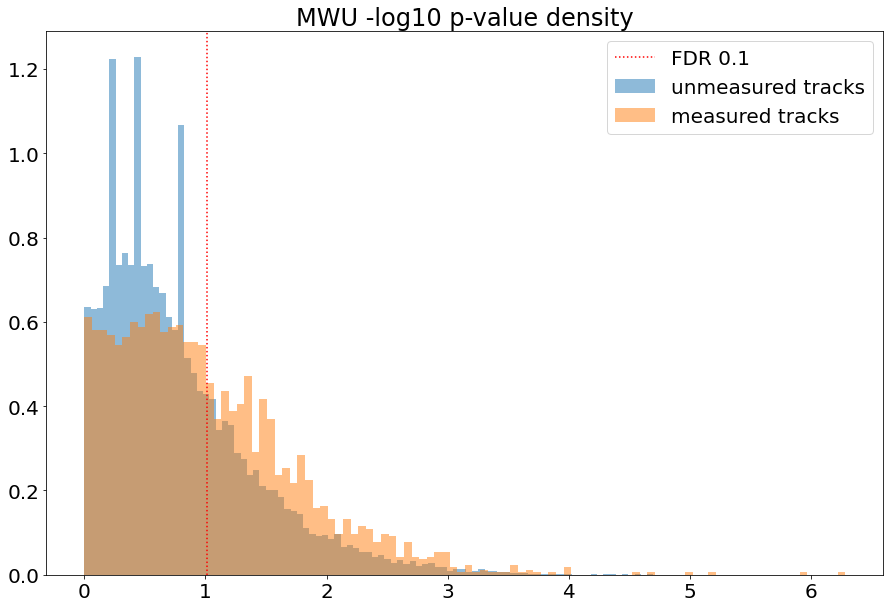

In [57]:
matplotlib.rcParams.update({'font.size': 20})
plt.figure(figsize=(15, 10))
plt.hist(z_mwu_log_pvals[track_mask == -1].flatten(), bins=100, density=True, alpha=0.5, label="unmeasured tracks")
plt.hist(z_mwu_log_pvals[track_mask != -1].flatten(), bins=100, density=True, alpha=0.5, label="measured tracks")
plt.axvline(-np.log10(z_fdr_pval_cutoff), linestyle=':', c='red', label=f'FDR {fdr}')
plt.title('MWU -log10 p-value density')
plt.legend()
plt.show()

In [58]:
res = mannwhitneyu(z_mwu_log_pvals[track_mask != -1].flatten(), z_mwu_log_pvals[track_mask == -1].flatten(),)
res.pvalue

3.624510518534118e-49

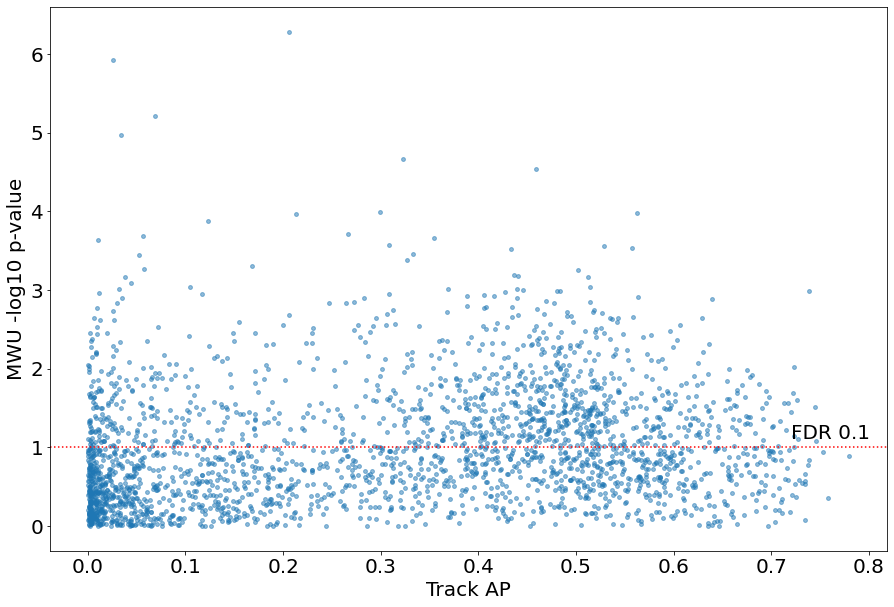

In [59]:
matplotlib.rcParams.update({'font.size': 20})
plt.figure(figsize=(15, 10))
plt.scatter(track_ap[track_ap != -1], z_mwu_log_pvals[track_ap != -1], s=15, alpha=0.5)
plt.axhline(-np.log10(z_fdr_pval_cutoff), linestyle=':', c='red')
plt.text(0.72, -np.log10(z_fdr_pval_cutoff) + 0.1, f'FDR {fdr}')
plt.xlabel('Track AP')
plt.ylabel('MWU -log10 p-value')
plt.show()

In [61]:
zhou_vars = load_variants('Zhou_etal.snv.hg19.TSS_flank50Kbp.vcf')

In [62]:
z_fid_diffs = []
for fid in zhou_vars["FID"].unique():
    try:
        fid_mean_control = np.load(zhou_path(f'mean_control_effect_{fid}.npy'))
        fid_mean_case = np.load(zhou_path(f'mean_case_effect_{fid}.npy'))
        z_fid_diffs.append(fid_mean_case - fid_mean_control)
    except FileNotFoundError:
        continue
z_fid_diffs = np.stack(z_fid_diffs)

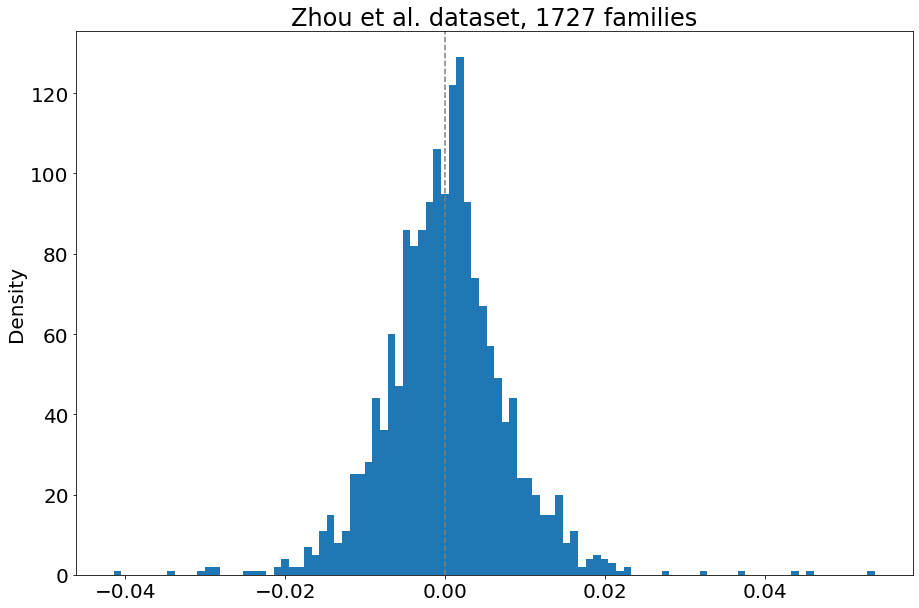

In [68]:
z_best_track_fid_diffs = z_fid_diffs[:, best_track_ct_idx, best_track_feat_idx]

matplotlib.rcParams.update({'font.size': 20})
plt.figure(figsize=(15, 10))
plt.hist(z_best_track_fid_diffs, bins=100)
plt.title(f"Zhou et al. dataset, {z_fid_diffs.shape[0]} families")
plt.ylabel('Density')
plt.xlabel('')
plt.axvline(0, linestyle='--', c='gray')
plt.show()

In [69]:
z_binom_pvals = np.full(z_fid_diffs.shape[1:], -1.)
for ct_idx in range(z_fid_diffs.shape[1]):
    for feat_idx in range(z_fid_diffs.shape[2]):
        track_fid_diffs = z_fid_diffs[:, ct_idx, feat_idx]
        res = binomtest((track_fid_diffs > 0).sum(), (track_fid_diffs).shape[0])
        z_binom_pvals[ct_idx, feat_idx] = res.pvalue

In [70]:
z_binom_pvals[best_track_ct_idx, best_track_feat_idx]

array([0.50046867])

In [71]:
(z_binom_pvals < 0.05).sum()

513

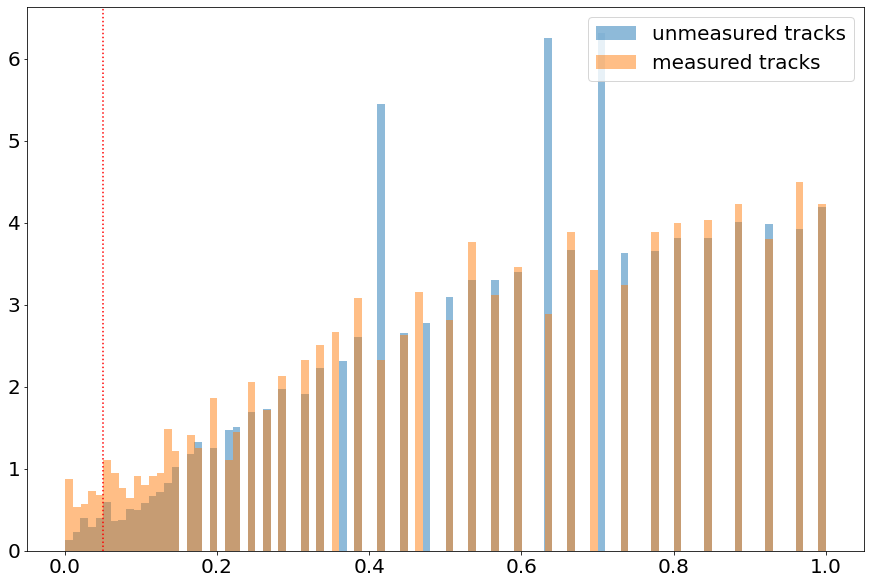

In [72]:
matplotlib.rcParams.update({'font.size': 20})
plt.figure(figsize=(15, 10))
plt.hist(z_binom_pvals[track_mask == -1].flatten(), density=True, bins=100, alpha=0.5, label="unmeasured tracks")
plt.hist(z_binom_pvals[track_mask != -1].flatten(), density=True, bins=100, alpha=0.5, label="measured tracks")
plt.axvline(0.05, c='red', linestyle=':')
plt.legend()
plt.show()

In [73]:
min_p_track_idx = np.where(z_binom_pvals == z_binom_pvals.min())
min_p_track_idx = (min_p_track_idx[0][0], min_p_track_idx[1][0])

In [76]:
z_binom_pvals.min()

0.0006291124405897314

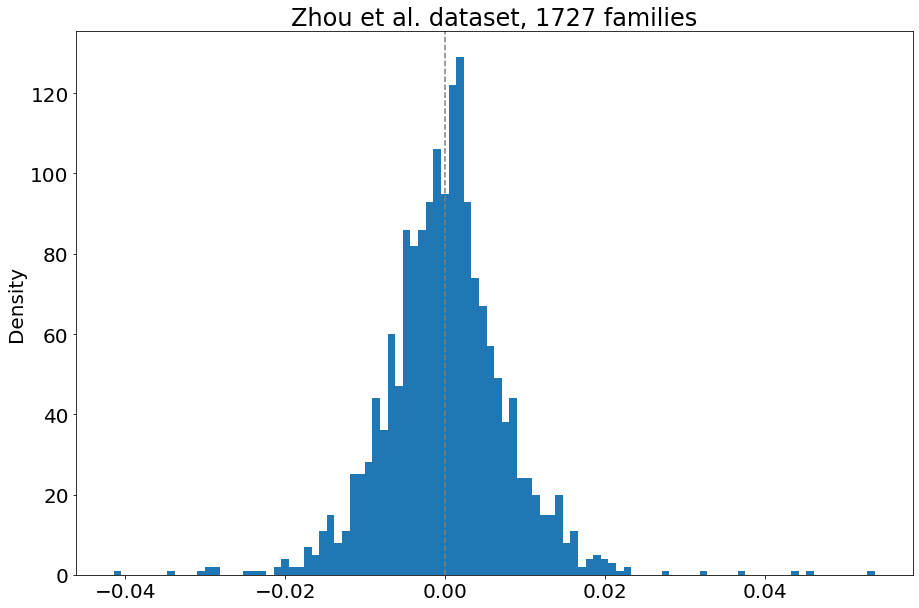

In [75]:
z_min_p_track_fid_diffs = z_fid_diffs[:, min_p_track_idx[0], min_p_track_idx[1]]

matplotlib.rcParams.update({'font.size': 20})
plt.figure(figsize=(15, 10))
plt.hist(z_best_track_fid_diffs, bins=100)
plt.title(f"Zhou et al. dataset, {z_fid_diffs.shape[0]} families")
plt.ylabel('Density')
plt.xlabel('')
plt.axvline(0, linestyle='--', c='gray')
plt.show()

In [77]:
(z_min_p_track_fid_diffs > 0).sum()

935

_____________

Order of all_effects

In [80]:
an_wrong_refs = pd.read_csv(an_path('wrong_refs.txt'), sep='\t', header=None)
an_wrong_refs = an_wrong_refs.drop_duplicates()

In [119]:
zhou_wrong_refs = pd.read_csv(zhou_path('wrong_refs.txt'), sep='\t', header=None)
zhou_wrong_refs = zhou_wrong_refs.drop_duplicates()

FileNotFoundError: [Errno 2] No such file or directory: 'predictions/40_features_q_mpi_highQCsamples/Zhou_etal.snv.hg19.TSS_flank50Kbp/wrong_refs.txt'

In [90]:
an_wrong_refs[(an_wrong_refs[0] == 'chr1') & (an_wrong_refs[1] == 145595694)].empty

True

In [120]:
def variants_order(variants, wrong_refs=None):
    case_variants_idxs = []
    control_variants_idxs = []
    
    fids = variants["FID"].unique()
    for fid in fids:
        family_variants = variants[variants["FID"] == fid]

        # set up for matched proband - sibling distribution
        for idx, variant in family_variants.iterrows():
            chrom = variant["CHROM"]
            pos = variant["POS"]
            case = variant["AUSTATUS"]
            if wrong_refs is None or wrong_refs[(wrong_refs[0] == chrom) & (wrong_refs[1] == pos)].empty:
                if case == 'case':
                    case_variants_idxs.append(idx)
                else:
                    control_variants_idxs.append(idx)
    return np.array(case_variants_idxs), np.array(control_variants_idxs)

In [107]:
an_case_idx_order, an_control_idx_order = variants_order(an_vars, an_wrong_refs)

In [109]:
an_all_cases = np.load(an_path('all_case_effects.npy'))

In [111]:
an_all_controls = np.load(an_path('all_control_effects.npy'))

In [117]:
an_vars.loc[an_case_idx_order, :].to_csv(an_path('all_case_effects_order.vcf'), sep='\t', index=False, header=None)

In [118]:
an_vars.loc[an_control_idx_order, :].to_csv(an_path('all_control_effects_order.vcf'), sep='\t', index=False, header=None)

In [121]:
zhou_case_idx_order, zhou_control_idx_order = variants_order(zhou_vars)

In [122]:
zhou_all_cases = np.load(zhou_path('all_case_effects.npy'))
zhou_all_controls = np.load(zhou_path('all_control_effects.npy'))

In [128]:
zhou_all_controls.shape

(27485, 794, 40)

In [127]:
zhou_control_idx_order.shape

(27485,)

In [129]:
zhou_vars.loc[zhou_case_idx_order, :].to_csv(zhou_path('all_case_effects_order.vcf'), sep='\t', index=False, header=None)
zhou_vars.loc[zhou_control_idx_order, :].to_csv(zhou_path('all_control_effects_order.vcf'), sep='\t', index=False, header=None)

In [108]:
len(an_case_idx_order)

50355

In [110]:
an_all_cases.shape

(50355, 794, 40)

In [112]:
an_all_controls.shape

(49858, 794, 40)

In [113]:
len(an_control_idx_order)

49858